In [1]:
import numpy as np
import pandas as pd
import sys,os,json
from collections import Counter

sys.path.insert(1, '/home/chacoma/librerias/python')
from plotter_lib import *

db = '/home/chacoma/Lineas/football_4/data/'

arx1 =db+'Sample_Game_1/Sample_Game_1_RawEventsData.csv' 
arx2 =db+'Sample_Game_2/Sample_Game_2_RawEventsData.csv' 


<h1> Obtención de redes

In [2]:
df = pd.read_csv(arx1)

df.head(10)

,#Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,#Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,Away,PASS,NaN,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
6,Away,PASS,NaN,1,279,11.16,303,12.12,Player22,Player17,0.39,0.96,0.49,0.98
7,Away,BALL LOST,INTERCEPTION,1,346,13.84,380,15.20,Player17,NaN,0.51,0.97,0.27,0.75
8,Home,RECOVERY,INTERCEPTION,1,378,15.12,378,15.12,Player2,NaN,0.27,0.78,NaN,NaN
9,Home,BALL LOST,INTERCEPTION,1,378,15.12,452,18.08,Player2,NaN,0.27,0.78,0.59,0.64


In [3]:
# diccionario de tiempo, segundo en el cual se dio pase, a pases
t2p={}

df2 = df.loc[ (df["#Team"]=="Home") & (df["Type"]=="PASS")]

for index, row in df2.iterrows():
       
    t = int(row["Start Time [s]"])
    n1 = row["From"]
    n2 = row["To"]
    
    try:
        t2p[t].append( "%s_%s"%(n1,n2) )
    except:
        t2p[t]=["%s_%s"%(n1,n2)]
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13.126605504587156 25.74845787562459
3.1399999999998727


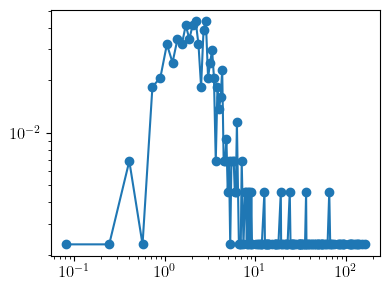

In [4]:
# tiempo entre pases

T = df2["Start Time [s]"].to_numpy()


dT = [ T[i+1]-T[i] for i in range(len(T)-1) ]

print(np.mean(dT), np.std(dT))
print(np.median(dT))

plot = Plotter()

mini =min(dT)
maxi = max(dT)


pars= [mini, maxi, (maxi-mini)/1000]
x,y= get_dist(dT, pars)


plot.ax.plot(x,y, marker='o')

plot.ax.set_yscale('log')
plot.ax.set_xscale('log')

plot.show()


In [5]:
# redes de pases 
try:
    aux = os.system("rm 1/*")
except: 
    None

Npases=50

count=0
Links=[]
red={}

for t,links in sorted(t2p.items(), key=lambda a:a[0]):
    
    
    for link in links:
        
        try:
            red[link]+=1
        except:
            red[link]=1
        
        Links.append(link)
    
    
        if len(Links)>Npases:

            a_sacar = Links[0]

            Links.pop(0)
            
            red[a_sacar]-=1
            
            if red[a_sacar]==0:
                 red.pop(a_sacar)
            
            #print (t,len(red))
            
            arxs = "1/%d.json"%t
            
            json.dump(red, open(arxs,"w"))
    

<h1> Calculo de métricas

In [6]:
import glob
import networkx as nx

arxs = glob.glob("1/*")

In [7]:
get_t = lambda s: int(s.split(".")[0].split("/")[-1])


X,Y = [],[]
nedges=[]

for arx in sorted(arxs, key = lambda s: get_t(s)):
    
    t = get_t(arx)
    d = json.load(open(arx,'r'))
    
    
    # armo un graph no dirigido---------------
    red={}
    seen=set()
    
    for players, w in d.items():
        n1, n2 = players.split('_')
        

        if (n1,n2) not in seen:

            if (n2,n1) not in seen:

                seen.add((n1,n2))

                red[(n1,n2)]=w

            else:
                red[(n2,n1)]+=w

        else:
            red[(n1,n2)]+=w
    # ------------------------------------------
    
    
    edgelist= [ "%s %s {'weight':%d}" % (nodos[0],nodos[1],w) for nodos,w in red.items() ]
    G = nx.parse_edgelist(edgelist, nodetype = str)
    
    nedges.append(G.number_of_edges())
    
    
    # clustering
    c= list(nx.clustering(G, weight="weight").values()) 
    
    # shortest path
    l = list( nx.all_pairs_dijkstra_path_length(G, weight="weight") ) 
    l2 = np.array([ list(l[i][1].values()) for i in range(len(l)) ]).flatten()
    sp = l2[l2!=0]
    
    # centralidad 
    ecs = np.array(list(nx.eigenvector_centrality(G, weight="weight").values()))
    ecs = ecs[ecs!=0]
    
    bcs = np.array(list(nx.betweenness_centrality(G, weight="weight").values()))
    bcs = bcs[bcs!=0]
     
    #assortatividad
    r= nx.degree_assortativity_coefficient(G, weight="weight")
    
    
    
    
    #variables
    a = r
    b = bcs
    
    #X.append( (np.var(a)+np.mean(a)**2)/np.mean(a) ) 
    #Y.append( (np.var(b)+np.mean(b)**2)/np.mean(b) ) 
    
    X.append(r)
    Y.append(np.std(b))

    
print(np.mean(nedges), np.std(nedges))
        

26.51595744680851 2.5010126966546022


376


<IPython.core.display.Javascript object>


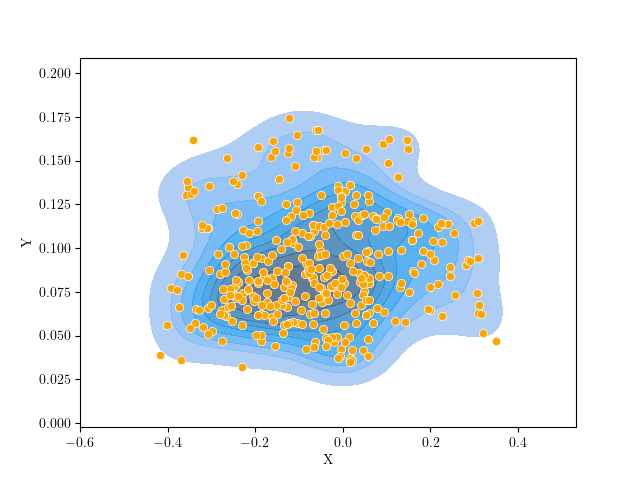

<Axes: xlabel='X', ylabel='Y'>

In [8]:
%matplotlib notebook
import seaborn as sb

print (len(X))


d={"X":X, "Y":Y}

sb.kdeplot( data=d, x="X", y="Y", fill=True, alpha=0.8)
sb.scatterplot(x='X', y='Y', data=d, color='orange')


